# Imports and Download

In this cells, import librairies, download and split the dataset.

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil, floor
import time
import shutil
from PIL import Image
from tqdm import tqdm
import copy

# sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, auc, accuracy_score, confusion_matrix, mean_squared_error, plot_confusion_matrix

# Torch
import torch
import torch.nn as nn
from torch.utils.data import Subset
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

# Torchvision
import torchvision as tv
from torchvision import datasets, transforms
import torchvision.transforms.functional as tf
from torchvision.models import resnet50
import torchvision.models as models


In [2]:
#Empty memory
import gc

gc.collect()

torch.cuda.empty_cache()

## Download Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Download and prepare the dataset
old_data_file = "/content/drive/MyDrive/mva/Recvis/bird_dataset"
new_data_file = "/content/drive/MyDrive/mva/Recvis/bird_dataset_splitted"
general_dir = "/content/drive/MyDrive/mva/Recvis"
experiment_dir = "/content/drive/MyDrive/mva/Recvis/experiments"
os.makedirs(experiment_dir, exist_ok=True)

def train_val_dataset(dataset, val_split=0.2, balanced=False):
  """ 
  Split the dataset in a training and validation test with the ratio val_split. 
  Input : dataset, val_split
  Output : Dictionnary dataset = {'train'; 'val'}
  """
  y = [dataset[i][1] for i in range(len(dataset))]
  train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split, random_state=42, stratify = y)
  datasets = {}
  datasets['train'] = Subset(dataset, train_idx)
  datasets['val'] = Subset(dataset, val_idx)
  return datasets

# Need to split data
do_a_new_split = False
if do_a_new_split:
  shutil.rmtree(new_data_file + "/train_images")
  shutil.rmtree(new_data_file + "/val_images")

if not os.path.exists(new_data_file):
  old_train_set = datasets.ImageFolder(old_data_file + "/train_images")
  old_val_set = datasets.ImageFolder(old_data_file + "/val_images")

  split_data = train_val_dataset(old_train_set.imgs + old_val_set.imgs) # split

  # Copy the split in another location
  os.makedirs(new_data_file)
  
  for key in split_data.keys():
    for file, _ in split_data[key]:
      cls, im = file.split("/")[-2:]
      os.makedirs(f"{new_data_file}/{key}/{cls}", exist_ok=True)
      shutil.copy(file, f"{new_data_file}/{key}/{cls}/{im}")

re_download_test_dataset = False
if re_download_test_dataset:
  old_test_set = datasets.ImageFolder(old_data_file + "/test_images")
  for file, _ in old_test_set.imgs:
    cls, im = file.split("/")[-2:]
    os.makedirs(f"{new_data_file}/test/{cls}", exist_ok=True)
    shutil.copy(file, f"{new_data_file}/test/{cls}/{im}")


# Load images
train_set_brut = datasets.ImageFolder(new_data_file + "/train")
val_set_brut = datasets.ImageFolder(new_data_file + "/val")
test_set_brut = datasets.ImageFolder(new_data_file + "/test")
set_brut = val_set_brut + train_set_brut

# Get information about the datasets

Insights about the splitting, the sizes and noise of images.

## Split informations

Get number of images in each set and each label.


In [ ]:
# Number of images in each dataset
print("Number of images in the training set", len(train_set_brut))
print("Number of images in the validation set", len(val_set_brut))
print("Number of images in the test set", len(test_set_brut))
print("Total number of images", len(train_set_brut)+len(val_set_brut)+len(test_set_brut))

Number of images in the training set 948
Number of images in the validation set 237
Number of images in the test set 517
Total number of images 1702


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


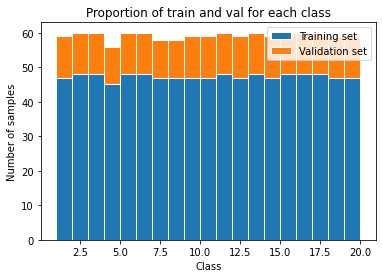

In [ ]:
# Check data repartition between train and val
nb_classes = 20
classes = {'val': [], 'train': []}

for _, c in val_set_brut:
  classes['val'].append(c)

for _, c in train_set_brut:
  classes['train'].append(c)

plt.hist([classes['train'],classes['val']], bins=[i+1 for i in range(nb_classes)], label=['Training set','Validation set'], histtype = 'barstacked',edgecolor = 'w')
plt.title("Proportion of train and val for each class")
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.legend()
plt.show()

## Images analysis


Image size distribution, Mean and variance of pixels.

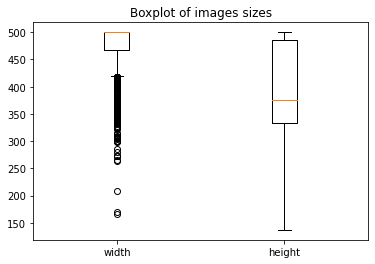

Text(0, 0.5, 'Number of images')

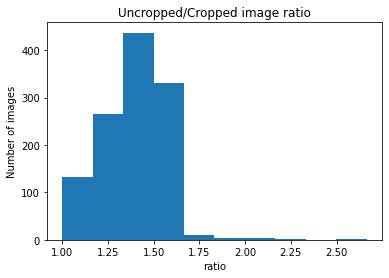

In [ ]:
# Get informations about images sizes of the training set
sizes = [[],[]]
ratio = []
pixels_train = {'Total': 0, 'Mean': [0, 0, 0], 'Variance': [0, 0, 0], 'width' : 0, 'height' : 0}
for im in set_brut:
  width, height = im[0].size
  pixels_train['width'] += width
  pixels_train['height'] += height
  pixels_train['Total'] += width * height
  pixels = np.array(im[0])/255
  for k in range(3):
    pixels_train['Mean'][k] += np.sum(pixels[:,:,k])
    pixels_train['Variance'][k] += np.sum(np.power(pixels,2)[:,:,k])
      
  sizes[0].append(width)
  sizes[1].append(height)
  if width > height:
    ratio.append(width/height)
  else:
    ratio.append(height/width)

fig, ax = plt.subplots()
ax.set_title('Boxplot of images sizes')
ax.boxplot(sizes, labels = ["width", "height"])
plt.show()

plt.hist(ratio)
plt.title('Uncropped/Cropped image ratio')
plt.xlabel('ratio')
plt.ylabel('Number of images')

The majority of images of the train dataset have a width equal to 500 and a height equal to 375. The size of images varies a lot. 

In [ ]:
# Get informations about the colors of the images of the train set
colors = ['Red', 'Green', 'Blue']
print('\nTrain set images mean size w x h:',  np.round(pixels_train['width']/len(train_set_brut)), np.round(pixels_train['height']/len(train_set_brut)))
print('Mean number of pixel per images', np.round(pixels_train['Total']/len(train_set_brut)))
print("RGB pixels mean and variance in the Train set: ")
mean = [0,0,0]
var = [0,0,0]
for k in range(3):
  mean[k] = pixels_train['Mean'][k]/pixels_train['Total']
  var[k] = pixels_train['Variance'][k]/pixels_train['Total'] - mean[k]**2
  print(colors[k], "mean", np.round(mean[k],2), "variance", np.round(var[k],2))

# Get informations about the colors of the images of the test set
pixels_test= {'Total': 0, 'Mean': [0, 0, 0], 'Variance': [0, 0, 0], 'width' : 0, 'height' : 0}
for im in test_set_brut:
  width, height = im[0].size
  pixels_test['width'] += width
  pixels_test['height'] += height
  pixels_test['Total'] += width * height
  pixels = np.array(im[0])/255
  for k in range(3):
    pixels_test['Mean'][k] += np.sum(pixels[:,:,k])
    pixels_test['Variance'][k] += np.sum(np.power(pixels,2)[:,:,k])

print('\nTest set images mean size w x h:',  np.round(pixels_test['width']/len(test_set_brut)), np.round(pixels_test['height']/len(test_set_brut)))
print('Mean number of pixel per images', np.round(pixels_test['Total']/len(test_set_brut)))
print("RGB pixels mean and variance in the Test set: ")
mean = [0,0,0]
var = [0,0,0]
for k in range(3):
  mean[k] = pixels_test['Mean'][k]/pixels_test['Total']
  var[k] = pixels_test['Variance'][k]/pixels_test['Total'] - mean[k]**2
  print(colors[k], "mean", np.round(mean[k],2), "variance", np.round(var[k],2))

pixels_ = {'Total': pixels_test['Total'] + pixels_train['Total'],
                'Mean': pixels_test['Mean'] + pixels_train['Mean'],
                'Variance': pixels_test['Variance'] + pixels_train['Variance']}
mean = []
var = []
for k in range(3):
  mean.append(np.round(pixels_['Mean'][k]/pixels_['Total'],2))
  var.append(np.round(pixels_['Variance'][k]/pixels_['Total'] - mean[k]**2,2))
custom_stats = (mean,var)

print("\nCustom Stats = ", custom_stats)


Train set images mean size w x h: 584.0 495.0
Mean number of pixel per images 228285.0
RGB pixels mean and variance in the Train set: 
Red mean 0.5 variance 0.06
Green mean 0.52 variance 0.06
Blue mean 0.44 variance 0.07

Test set images mean size w x h: 499.0 428.0
Mean number of pixel per images 213755.0
RGB pixels mean and variance in the Test set: 
Red mean 0.49 variance 0.05
Green mean 0.52 variance 0.05
Blue mean 0.42 variance 0.07

Custom Stats =  ([0.17, 0.18, 0.14], [0.07, 0.08, 0.06])


# Convolutionnal Neural Networks

Use convolutionnal Neural networks to classify images.

## Prepare for training

Use Data Augmentation and transfert learning

#### Training functions

In [5]:
def one_epoch_train(model, train_loader, epoch, optimizer, sched, criterion, device, grad_clip, logging_freq=5):
    """ Trains one epoch of the model over all batches"""
    model.train()
    lrs = []
    list_loss = []
    list_acc = []
    for batch_idx, batch in enumerate(train_loader):
        x, y = batch    
        x = x.to(device) 
        if isinstance(y, (tuple, list)): # If we use CutMix
            y1, y2, lam = y
            y = (y1.to(device), y2.to(device), lam)
        else: # Otherwise
            y = y.to(device)

        output = model(x)
        _, y_pred = torch.max(output, dim=1)
        loss = criterion(output, y)
        loss.backward()
        if grad_clip: # Do we apply grad_clipping or not 
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        optimizer.step()
        optimizer.zero_grad()


        if sched is not None: # Scheduler for each batch
          lrs.append(get_lr(optimizer))
          sched.step()

        if isinstance(y, (tuple, list)): # If we use CutMix
            y1, y2, lam = y
            correct1 = y_pred.eq(y1).sum().item()
            correct2 = y_pred.eq(y2).sum().item()
            acc = (lam * correct1 + (1 - lam) * correct2) / x.size(0)
        else: # Otherwise
            correct_ = y_pred.eq(y).sum().item()
            acc = correct_ / x.size(0)

        list_loss.append(loss.data.item())
        list_acc.append(acc)

        if batch_idx % logging_freq == 0: # Print scores
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.0f}%'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item(),
                acc * 100.))
    return model, np.mean(list_loss), np.mean(list_acc), lrs

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def compute_validation(model, val_loader, criterion, device):
    """ Get scores on the validation dataset"""
    model.eval()
    list_loss = []
    list_acc = []
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch            
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            list_loss.append(criterion(y_pred, y).data.item())
            list_acc.append(accuracy_score([val.item() for val in y], [val.item() for val in y_pred.argmax(dim=-1)])) 
    loss = np.mean(list_loss)
    acc = np.mean(list_acc)
    print('Validation set: Average loss: {:.4f}, Accuracy: {:.0f}%\n'.format(
        loss, acc * 100.))
    return loss, acc

def save_model(model, epoch, directory=experiment_dir):
    """ Save weights"""
    os.makedirs(f"{directory}/{model.name}", exist_ok=True)
    model_file = f"{directory}/{model.name}/{epoch}.pth"
    torch.save(model.state_dict(), model_file)

def training(model, train_loader, val_loader, optimizer, scheduler, num_epochs, criterion, device, grad_clip=None, threshold=0.87):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    lrs = []
    best_model = model
    best_epoch = 1

    if len(criterion)>1:
      criterion_val = criterion[1]
      criterion_train = criterion[0]
    else:
      criterion_val = criterion[0]
      criterion_train = criterion[0]

    for epoch in range(num_epochs):
        # Adapt to scheduler
        if scheduler is None : 
            # No scheduler
            model, t_loss, t_acc, lr = one_epoch_train(model, train_loader, epoch, optimizer, None, criterion_train, device, grad_clip)
            lrs.append(get_lr(optimizer))
        elif (scheduler.state_dict()['total_steps'] > num_epochs if 'total_steps' in scheduler.state_dict().keys() else False): 
            # Scheduler step at each batch
            model, t_loss, t_acc, lr = one_epoch_train(model, train_loader, epoch, optimizer, scheduler, criterion_train, device, grad_clip)
            lrs = lrs + lr
        else:
            # Scheduler step at each epoch
            model, t_loss, t_acc, lr = one_epoch_train(model, train_loader, epoch, optimizer, None, criterion_train, device, grad_clip)
            lrs.append(get_lr(optimizer))
            scheduler.step()

        train_loss.append(t_loss)
        train_acc.append(t_acc)
               
        v_loss, v_acc = compute_validation(model, val_loader, criterion_val, device)     
        val_loss.append(v_loss)
        val_acc.append(v_acc)

        if v_loss == min(val_loss): # Keep track of best model
            best_model = model
            best_epoch = epoch
        if (v_acc > threshold) and (v_loss < min(val_loss)*1.01) : # Save model
                save_model(model, epoch)
    print("\nBest results for epoch ", best_epoch)
    compute_validation(best_model, val_loader, criterion_val, device)
    return best_model, val_acc, val_loss, train_acc, train_loss, lrs


def print_accuracy_and_loss(val_acc, val_loss, train_acc, train_loss, lrs):
    """ Print learning curves"""
    epoch_linspace = np.linspace(0,len(val_acc),len(val_acc))
    # Print Accuracy evolution 
    plt.plot(epoch_linspace, val_acc, label='Validation')
    plt.plot(epoch_linspace, train_acc, label='Training')
    plt.title("Accuracy evolution during the training")
    plt.xlabel("Epochs")
    plt.ylabel("Acuracy")
    plt.legend()
    plt.show()

    # Print Loss evolution
    plt.plot(epoch_linspace, val_loss, label='Validation')
    plt.plot(epoch_linspace, train_loss, label='Training')
    plt.title("Loss evolution during the training")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Print lr evolution
    plt.plot(np.linspace(0,len(lrs),len(lrs)), lrs)
    plt.title("Learning rate evolution during the training")
    plt.xlabel("batches or epochs")
    plt.ylabel("lr")
    plt.show()

def evaluation_file(model, data_transforms, test_dir, general_dir, file_name):
  use_cuda = torch.cuda.is_available()
  output_file = open(file_name, "w")
  output_file.write("Id,Category\n")
  for f in tqdm(os.listdir(test_dir)):
      if 'jpg' in f:
          data = data_transforms(pil_loader(test_dir + '/' + f))
          data = data.view(1, data.size(0), data.size(1), data.size(2))
          if use_cuda:
              model = model.cuda()
              data = data.cuda()
          output = model(data)
          pred = output.data.max(1, keepdim=True)[1]
          output_file.write("%s,%d\n" % (f[:-4], pred))
  output_file.close()
  print("Succesfully wrote file , you can upload this file to the kaggle competition website")

def evaluation_file_bagging(models, data_transforms, test_dir, general_dir, file_name, nclasses=20):
  """ Evaluate file using a list of models"""
  use_cuda = torch.cuda.is_available()
  output_file = open(file_name, "w")
  output_file.write("Id,Category\n")
  for f in tqdm(os.listdir(test_dir)):
      if 'jpg' in f:
          data = data_transforms(pil_loader(test_dir + '/' + f))
          data = data.view(1, data.size(0), data.size(1), data.size(2))
          vote = np.zeros(nclasses)
          for k in range(len(models)):
              if use_cuda:
                  data = data.cuda()
                  models[k] = models[k].cuda()
              models[k].eval()
              output = models[k](data) 

              # We sum all models probability for all classes
              # output = output[0]
              # for i in range(nclasses):
              #     vote[i] += output[i]

              # Each model vote for a class
              pred = output.data.max(1, keepdim=True)[1]
              vote[pred.item()] += 1

          output_file.write("%s,%d\n" % (f[:-4], np.argmax(vote)))
  output_file.close()
  print("Succesfully wrote file , you can upload this file to the kaggle competition website")

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

### Data Augmentation

In [6]:
# Preprocessing of the dataset

class Padding:
  """
  Creates images with all the same ratio by adding a zero padding
  """
  def __init__(self, ratio, fixed_size):
    self.ratio = ratio
    self.size = fixed_size

  def __call__(self, img_tensor):
    h, w = img_tensor.shape[1], img_tensor.shape[2]
    if self.size > max(h,w):
      if h > w:
        d_h = max(0, self.size - h)
        d_w = max(0, int(self.size/self.ratio) - w)
      else:
        d_w = max(0, self.size - w)
        d_h = max(0, int(self.size/self.ratio) - h)
      pad = (d_w // 2, d_h // 2, d_w - d_w//2, d_h - d_h // 2)

    else:
      if w > h:
        d = abs(int(w/self.ratio) - h)
        pad = (0, d//2, 0, d - (d//2))
        return(tf.pad(img_tensor, pad))
      elif h >= w:
        d = abs(int(h / self.ratio) - w)
        pad = (d//2, 0, d - (d//2), 0)   
    return(tf.pad(img_tensor, pad, padding_mode='reflect'))

class CorrectRatio:
  """Apply same ratio for all image thanks to center croping"""
  def __init__(self, ratio):
    self.ratio = ratio

  def __call__(self, img_tensor):
    h, w = img_tensor.shape[1], img_tensor.shape[2]
    if w > h:
      return transforms.CenterCrop((h, int(self.ratio*h)))(img_tensor)
    elif h > w:
      return transforms.CenterCrop((int(self.ratio*w), w))(img_tensor)
    return img_tensor

def print_images_from_loader(loader, nb_images=5):
    fig = plt.figure(figsize=(20,20*nb_images))
    for i in range(nb_images):
        tensor = next(iter(loader))[0][i]
        fig.add_subplot(1, nb_images,i+1)
        plt.imshow(tensor.permute(1, 2, 0).cpu())
    plt.show()


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


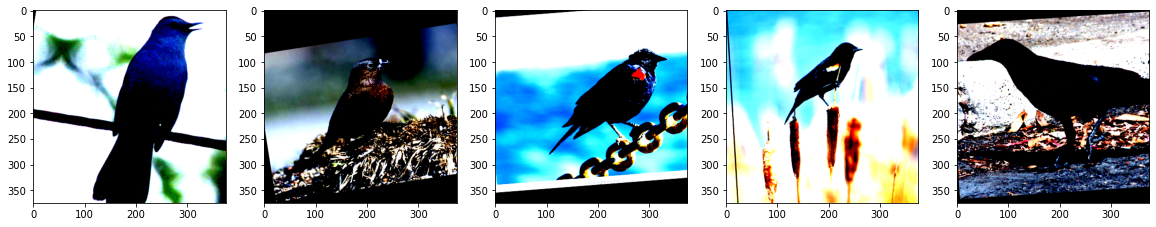

In [7]:
# Parameters
nb_classes = 20
batch_s = 32
batch_s_val = 64
img_size = (375,375)
ratio_padding = 1
size_padding = 400
ratio_crop = 1.37
stats = ((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
custom_stat = ([0.17, 0.18, 0.14], [0.07, 0.08, 0.06])
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define transforms
transformer_train = transforms.Compose([
    transforms.ToTensor(),
    tv.transforms.Normalize(*stats),
    Padding(ratio=ratio_padding, fixed_size=size_padding),
    tv.transforms.RandomOrder([
      transforms.RandomHorizontalFlip(p=0.4),
      transforms.RandomRotation(10, resample=Image.BILINEAR),]),
    tv.transforms.RandomCrop(img_size),
    #CorrectRatio(ratio_crop),
    #transforms.Resize(img_size),
    #BirdCropper(device),
    ])

transformer_eval = tv.transforms.Compose([
    transforms.ToTensor(),
    #Padding(ratio=ratio_padding, fixed_size=size_padding),
    tv.transforms.CenterCrop(img_size),
    tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Image Loader
train_set = datasets.ImageFolder(new_data_file + "/train", transform=transformer_train)
val_set = datasets.ImageFolder(new_data_file + "/val", transform=transformer_eval)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_s)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=batch_s_val)

print_images_from_loader(train_loader)

### Transfert Learning

In [8]:

from torchvision.models import resnet50, resnet152, densenet161, resnext101_32x8d
class BirdResnet(nn.Module):
    def __init__(self,nb_classes=20,name="BirdResnet"):
        super().__init__()
        self.name = name
        # Use a pretrained model
        self.network = resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 1024)
        self.linear = nn.Linear(1024, nb_classes)
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = self.network(x)
        x = self.dropout(x)
        x = F.relu(self.linear(x))
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
        for param in self.linear.parameters():
            param.require_grad = True
    
    def unfreeze_few_layers(self):
        for param in self.network.layer3.parameters():
            param.require_grad = True
        for param in self.network.layer4.parameters():
            param.require_grad = True

    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True
        for param in self.linear.parameters():
            param.require_grad = True



class BirdNet(nn.Module):
    def __init__(self,backbone="resnet",nb_classes=20,name=None):
        super().__init__()

        if name is not None:
          self.name = name
        else:
          self.name = backbone

        # Use a pretrained model
        if backbone == "resnet":
            network = resnet50(pretrained=True)
        elif backbone == 'resnet152':
            network = resnet152(pretrained=True)
        elif backbone == 'resnext101_32x8d':
            network = resnext101_32x8d(pretrained=True)
        self.network = nn.Sequential(*list(network.children())[:-1])  

        # Replace last layers
        num_ftrs = network.fc.in_features
        self.linear1 = nn.Linear(num_ftrs, 1024)
        self.linear2 = nn.Linear(1024, nb_classes)
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.4)
        self.bn1 = nn.BatchNorm1d(1024)
        self.classifier = nn.Sequential(self.dropout1, self.linear1, self.bn1, self.dropout2, self.linear2)
    
    
    def forward(self, x):
        x = self.network(x)
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = F.relu(self.linear1(x))
        x = self.bn1(x)
        x = self.dropout2(x)
        x = F.relu(self.linear2(x))
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.classifier.parameters():
            param.require_grad = True
    
    def unfreeze_few_layers(self):
        for param in self.network[4].parameters():
            param.require_grad = True
        for param in self.network[6].parameters():
            param.require_grad = True

    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True
        for param in self.linear.parameters():
            param.require_grad = True



## Training on Resnet50

Using differents optimizer, learning rate scheduler, freezing differents numbers of layers. 

In [ ]:
# Choose model
model = BirdNet().to(device)
model.freeze()
model

In [ ]:
batch_s = 32
batch_s_val = batch_s*2

transformer_train = transforms.Compose([
    transforms.ToTensor(),
    tv.transforms.Normalize(*stats),
    Padding(ratio=ratio_padding, fixed_size=size_padding),
    tv.transforms.RandomOrder([
      transforms.RandomHorizontalFlip(p=0.4),
      transforms.RandomRotation(10, resample=Image.BILINEAR),]),
    tv.transforms.RandomCrop(img_size),
    #CorrectRatio(ratio_crop),
    #transforms.Resize(img_size),
    #BirdCropper(device),
    ])

transformer_eval = tv.transforms.Compose([
    transforms.ToTensor(),
    #Padding(ratio=ratio_padding, fixed_size=size_padding),
    tv.transforms.CenterCrop(img_size),
    tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Image Loader
train_set = datasets.ImageFolder(new_data_file + "/train", transform=transformer_train)
val_set = datasets.ImageFolder(new_data_file + "/val", transform=transformer_eval)
test_set = datasets.ImageFolder(new_data_file + "/test", transform=transformer_eval)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_s)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=batch_s_val)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=batch_s_val)

print_images_from_loader(test_loader)

### First experiment

For the Data augmentation : Normalizer, Padding to make image square, Random Horizontal Flip and Rotation.

Adam Optimizer with OneCycleLR scheduler, weight decay and gradient clipping.

Best score (epoch 15):
Loss = 0.4444
Acc = 89%

In [ ]:
# Choose model
model = BirdResnet(nb_classes, name="BirdResnet_").to(device)
model.freeze()
model

# Parameters of the training
num_epochs = 25
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
nb_classes = 20
grad_clip = 0.1
weight_decay = 1e-4
max_lr = 0.0001

#

# instantiate optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, 
                                                steps_per_epoch=len(train_loader))
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) #optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

# Train the model
model, val_acc, val_loss, train_acc, train_loss, lrs = training(model, train_loader, val_loader, optimizer, scheduler, num_epochs, criterion, device, grad_clip)

# Test accuracy
# test_accuracy = test_model(model, test_loader, device)
# print('Test accuracy: {:.3f}'.format(test_accuracy))

# Print Accuracy and loss evolution 
print_accuracy_and_loss(val_acc, val_loss, train_acc, train_loss, lrs)

### Experiment 2

Same as experiment 1, but adding dropout and batch normalisation in the model.

Best score (epoch 10):
Loss = 0.4070
Acc = 90%

In [ ]:
# Choose model
model = BirdNet(backbone="resnet",nb_classes=20, name="BirdResnet_2").to(device)
model.freeze()
model

# Parameters of the training
num_epochs = 25
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
nb_classes = 20
grad_clip = 0.1
weight_decay = 1e-4
max_lr = 0.0001

#

# instantiate optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, 
                                                steps_per_epoch=len(train_loader))
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) #optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

# Train the model
model, val_acc, val_loss, train_acc, train_loss, lrs = training(model, train_loader, val_loader, optimizer, scheduler, num_epochs, criterion, device, grad_clip)

# Test accuracy
# test_accuracy = test_model(model, test_loader, device)
# print('Test accuracy: {:.3f}'.format(test_accuracy))

# Print Accuracy and loss evolution 
print_accuracy_and_loss(val_acc, val_loss, train_acc, train_loss, lrs)

### Experiment 3

We change the scheduler and optimizer.

Best score (epoch 14):
Loss = 0. 3219
Acc = 90%

In [ ]:
# Choose model
model = BirdNet(backbone="resnet",nb_classes=20, name="BirdResnet_3").to(device)
model.freeze()
model

# Parameters of the training
num_epochs = 20
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
nb_classes = 20
grad_clip = None
weight_decay = 1e-4
max_lr = 0.0001

# instantiate optimizer and scheduler
optimizer = optim.Adam([{'params': model.network.parameters(), 'lr': 1e-5}, {'params': model.classifier.parameters(), 'lr': 1e-4}])
#optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = None
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) 
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

# Train the model
model, val_acc, val_loss, train_acc, train_loss, lrs = training(model, train_loader, val_loader, optimizer, scheduler, num_epochs, criterion, device, grad_clip)

# Print Accuracy and loss evolution 
print_accuracy_and_loss(val_acc, val_loss, train_acc, train_loss, lrs)

### Experiment 4

Same as experiment 2, but we unfreeze some deeper layers.


Best score (epoch 12):
Loss = 0.4190
Acc = 91%

In [ ]:
# Choose model
model = BirdNet(backbone="resnet",nb_classes=20, name="BirdResnet_4").to(device)
model.freeze()
model.unfreeze_few_layers()
model

# Parameters of the training
num_epochs = 20
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
nb_classes = 20
grad_clip = 0.1
weight_decay = 1e-4
max_lr = 0.0001

#

# instantiate optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, 
                                                steps_per_epoch=len(train_loader))
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) #optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

# Train the model
model, val_acc, val_loss, train_acc, train_loss, lrs = training(model, train_loader, val_loader, optimizer, scheduler, num_epochs, criterion, device, grad_clip)

# Test accuracy
# test_accuracy = test_model(model, test_loader, device)
# print('Test accuracy: {:.3f}'.format(test_accuracy))

# Print Accuracy and loss evolution 
print_accuracy_and_loss(val_acc, val_loss, train_acc, train_loss, lrs)


### Experiment 5

Same as experiment 3, but we unfreeze some deeper layers.

Best score (epoch 14):
Loss = 0.3408 
Acc = 89%

In [ ]:
# Choose model
model = BirdNet(backbone="resnet",nb_classes=20, name="BirdResnet_5").to(device)
model.freeze()
model.unfreeze_few_layers()
model

# Parameters of the training
num_epochs = 20
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
nb_classes = 20
grad_clip = None
weight_decay = 1e-4
max_lr = 0.0001

# instantiate optimizer and scheduler
optimizer = optim.Adam([{'params': model.network.parameters(), 'lr': 1e-5}, {'params': model.classifier.parameters(), 'lr': 1e-4}])
#optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = None
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) 
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

# Train the model
model, val_acc, val_loss, train_acc, train_loss, lrs = training(model, train_loader, val_loader, optimizer, scheduler, num_epochs, criterion, device, grad_clip)

# Print Accuracy and loss evolution 
print_accuracy_and_loss(val_acc, val_loss, train_acc, train_loss, lrs)

### Experiment 6

Same as 5 but add a scheduler

Best results for epoch  13
Validation set: Average loss: 0.3636, Accuracy: 88%

In [ ]:
# Choose model
model = BirdNet(backbone="resnet",nb_classes=20, name="BirdResnet_6").to(device)
model.freeze()
model

# Parameters of the training
num_epochs = 20
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
nb_classes = 20
grad_clip = None
weight_decay = 1e-4
max_lr = 0.0001

# instantiate optimizer and scheduler
optimizer = optim.Adam([{'params': model.network.parameters(), 'lr': 1e-5}, {'params': model.classifier.parameters(), 'lr': 1e-4}])
#optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

# Train the model
model, val_acc, val_loss, train_acc, train_loss, lrs = training(model, train_loader, val_loader, optimizer, scheduler, num_epochs, criterion, device, grad_clip)

# Print Accuracy and loss evolution 
print_accuracy_and_loss(val_acc, val_loss, train_acc, train_loss, lrs)

### Experiment 7

Same as experiment 2 and 4, but we unfreeze all layers.

Best results for epoch  14
Validation set: Average loss: 0.4420, Accuracy: 89%


In [ ]:
# Choose model
model = BirdNet(backbone="resnet",nb_classes=20, name="BirdResnet_7").to(device)
model

# Parameters of the training
num_epochs = 20
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
nb_classes = 20
grad_clip = 0.1
weight_decay = 1e-4
max_lr = 0.0001

#

# instantiate optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, 
                                                steps_per_epoch=len(train_loader))
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) #optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

# Train the model
model, val_acc, val_loss, train_acc, train_loss, lrs = training(model, train_loader, val_loader, optimizer, scheduler, num_epochs, criterion, device, grad_clip)

# Test accuracy
# test_accuracy = test_model(model, test_loader, device)
# print('Test accuracy: {:.3f}'.format(test_accuracy))

# Print Accuracy and loss evolution 
print_accuracy_and_loss(val_acc, val_loss, train_acc, train_loss, lrs)

## Training with other pre-trained models


I dit the same experiences with two other resnet models. 
The Adam Optimize with OneCycleLr scheduler and some deep layers unfrozen but not all of them is the best way to train our model. 

In [ ]:
batch_s = 16
batch_s_val = batch_s*2

transformer_train = transforms.Compose([
    transforms.ToTensor(),
    tv.transforms.Normalize(*stats),
    Padding(ratio=ratio_padding, fixed_size=size_padding),
    tv.transforms.RandomOrder([
      transforms.RandomHorizontalFlip(p=0.4),
      transforms.RandomRotation(10, resample=Image.BILINEAR),]),
    tv.transforms.RandomCrop(img_size),
    #CorrectRatio(ratio_crop),
    #transforms.Resize(img_size),
    #BirdCropper(device),
    ])

transformer_eval = tv.transforms.Compose([
    transforms.ToTensor(),
    #Padding(ratio=ratio_padding, fixed_size=size_padding),
    tv.transforms.CenterCrop(img_size),
    tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Image Loader
train_set = datasets.ImageFolder(new_data_file + "/train", transform=transformer_train)
val_set = datasets.ImageFolder(new_data_file + "/val", transform=transformer_eval)
#test_set = datasets.ImageFolder(new_data_file + "/test", transform=transformer_eval)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_s)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=batch_s_val)
#test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=batch_s_val)

print_images_from_loader(train_loader)

### Resnet152

Change the pretrained model from resnet50 to resnet152.

In [ ]:
# Choose model
model = BirdNet(backbone='resnet152').to(device)
model.freeze()
model.unfreeze_few_layers()
model

# Parameters of the training
num_epochs = 10
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
nb_classes = 20
grad_clip = 0.1
weight_decay = 1e-4
max_lr = 0.00005

# instantiate optimizer and scheduler
#optimizer = optim.Adam([{'params': list(model.children())[0].parameters(), 'lr': 1e-4},], lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) 
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

# Train the model
model, val_acc, val_loss, train_acc, train_loss, lrs = training(model, train_loader, val_loader, optimizer, scheduler, num_epochs, criterion, device, grad_clip)

# Test accuracy
# test_accuracy = test_model(model, test_loader, device)
# print('Test accuracy: {:.3f}'.format(test_accuracy))

# Print Accuracy and loss evolution 
print_accuracy_and_loss(val_acc, val_loss, train_acc, train_loss, lrs)

### Resnext101_32x8d

Change the pretrained model from resnet50 to 'resnext101_32x8d'.

In [ ]:
# Choose model
model = BirdNet(backbone='resnext101_32x8d').to(device)
model.freeze()
model.unfreeze_few_layers()
model

# Parameters of the training
num_epochs = 10
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
nb_classes = 20
grad_clip = 0.1
weight_decay = 1e-4
max_lr = 0.00005

# instantiate optimizer and scheduler
#optimizer = optim.Adam([{'params': list(model.children())[0].parameters(), 'lr': 1e-4},], lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) 
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

# Train the model
model, val_acc, val_loss, train_acc, train_loss, lrs = training(model, train_loader, val_loader, optimizer, scheduler, num_epochs, criterion, device, grad_clip)

# Test accuracy
# test_accuracy = test_model(model, test_loader, device)
# print('Test accuracy: {:.3f}'.format(test_accuracy))

# Print Accuracy and loss evolution 
print_accuracy_and_loss(val_acc, val_loss, train_acc, train_loss, lrs)

## Further Experiments 




### Transforms : BirdCropper


I tried to crop images around the bird as a preprocessing, using a detection model pre-trained and the boxes it detect.

In [9]:

from torchvision.models.detection import maskrcnn_resnet50_fpn

class BirdCropper:
    """Crop around the bird thanks to a bird detection model

    Will also perform the correctRatio task. If no bird is found it will just apply CorrectRatio.
    """
    BIRD_CLASS = 20
    detector = maskrcnn_resnet50_fpn(pretrained=True).to(device)
    detector.eval()
    COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


    def __init__(self, device, detection_threshold=0.2, size_padding=400, ratio=1, alpha=1):
        """parameters:
        detection_threshold : minimum detection score accepted
        size_padding : size for padding in case we don't find the bird
        ratio : the ratio we want for the image
        alpha : the increase in size of the bounding box for birds detected"""  
        self.device = device
        self.detection_threshold = detection_threshold
        self.alpha = alpha
        self.ratio = ratio
        self.default_operator = transforms.Compose([Padding(ratio=ratio, fixed_size=size_padding),CorrectRatio(ratio)]) # If bird is not found

    def __call__(self, tensor):
        img = tensor.view(-1, *tensor.shape).to(device)[0]
        pred = self.detector([img])
        pred_score = list(pred[0]['scores'].detach().cpu().numpy())
        pred_class = [self.COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].detach().cpu().numpy())]
        pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(pred[0]['boxes'].detach().cpu().numpy())]

        idx_bird = [pred_class.index(x) for x in pred_class if x=='bird']
        if len(idx_bird) > 0:
            best_idx = None
            best_pred = 0
            for idx in idx_bird:
                if pred_score[idx] > best_pred:
                    best_pred = pred_score[idx]
                    best_idx = idx

            if (self.detection_threshold is None or best_pred > self.detection_threshold):
                x_min, y_min, x_max, y_max = pred_boxes[best_idx]
                H, W = img.shape[1], img.shape[2]
                mid_x = 0.5 * (x_min + x_max)
                mid_y = 0.5 * (y_min + y_max)

                width = self.alpha * (x_max - x_min)
                height = self.alpha * (y_max - y_min)
                height = max(height, width/self.ratio)
                width = max(width, height/self.ratio)

                x1 = max(0, int(mid_x - width/2))
                x2 = min(W-1, int(mid_x + width/2))
                y1 = max(0, int(mid_y - height/2))
                y2 = min(H-1, int(mid_y + height/2))
                return img[:, y1:y2+1, x1:x2+1]

            else:  # if no bird has been detected
                print('Bird prediction score < threshold')
          
        else:  # if nothing has been detected
            print('No birds')
        return self.default_operator(img)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RG

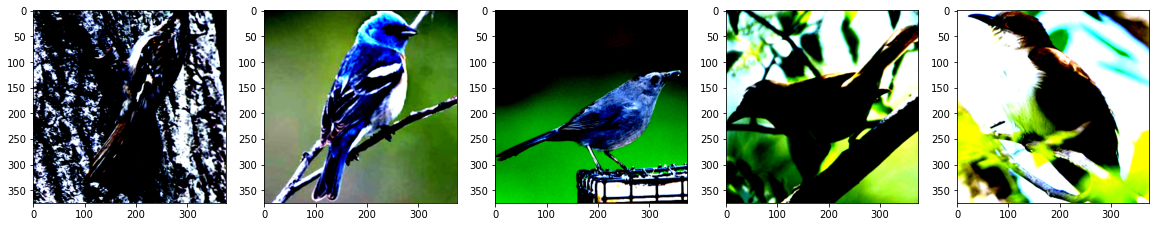

In [15]:
# Parameters
nb_classes = 20
batch_s = 32
batch_s_val = 64
img_size = (375,375)
ratio_padding = 1
size_padding = 400
ratio_crop = 1.37
stats = ((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


batch_s = 16
batch_s_val = batch_s*2

transformer_train = transforms.Compose([
    transforms.ToTensor(),
    #Padding(ratio=ratio_padding, fixed_size=size_padding),
    tv.transforms.RandomOrder([
      transforms.RandomHorizontalFlip(p=0.4),
      transforms.RandomRotation(10, resample=Image.BILINEAR),]),
    #tv.transforms.RandomCrop(img_size),
    #CorrectRatio(ratio_crop),
    #transforms.Resize(img_size),
    BirdCropper(device, ratio=ratio_padding, size_padding=size_padding, detection_threshold=None),
    transforms.Resize(img_size),
    tv.transforms.Normalize(*stats),
    ])

transformer_eval = transforms.Compose([
    transforms.ToTensor(),
    #Padding(ratio=ratio_padding, fixed_size=size_padding),
    BirdCropper(device),
    transforms.Resize(img_size),
    tv.transforms.Normalize(*stats),
    ])

#collator =  CutMixCollator(1)
# Image Loader
train_set = datasets.ImageFolder(new_data_file + "/train", transform=transformer_train)
val_set = datasets.ImageFolder(new_data_file + "/val", transform=transformer_eval)
test_set = datasets.ImageFolder(new_data_file + "/test", transform=transformer_eval)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_s)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=batch_s_val)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=batch_s_val)

print_images_from_loader(train_loader)

  0%|          | 0/4 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


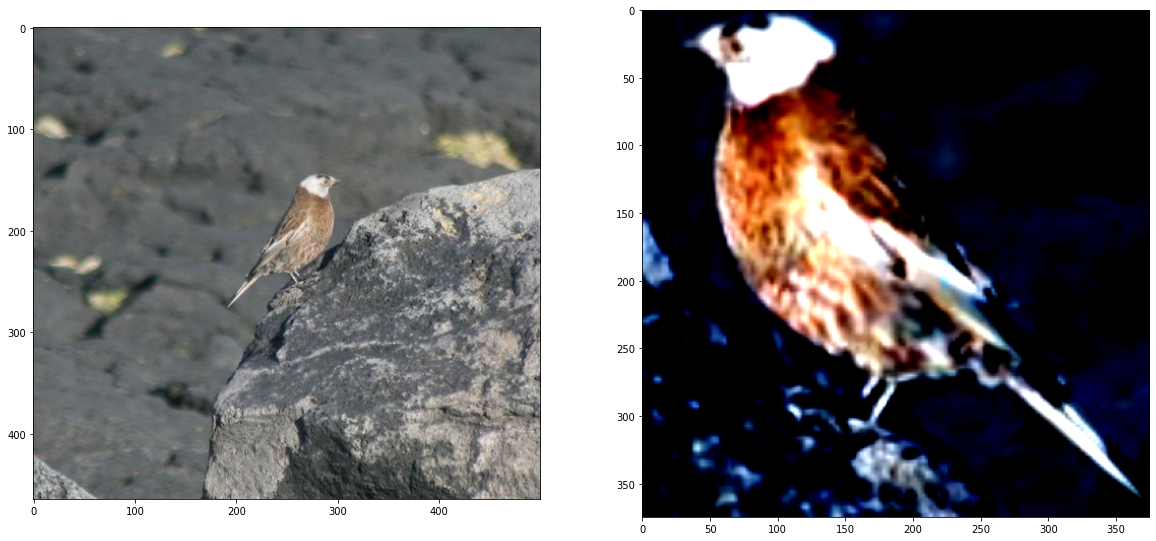

 25%|██▌       | 1/4 [00:00<00:02,  1.11it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


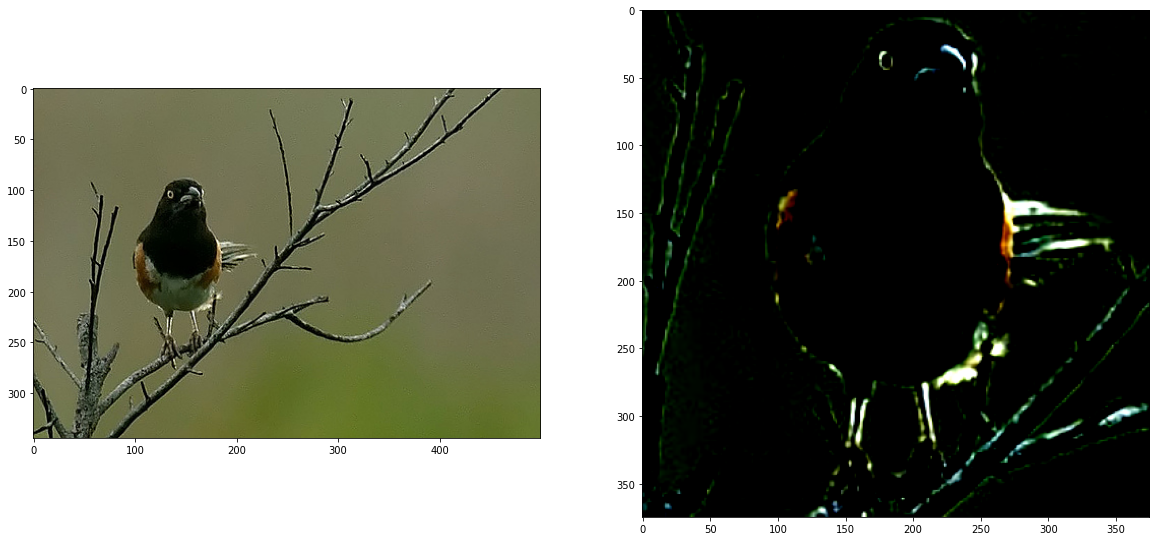

 50%|█████     | 2/4 [00:01<00:01,  1.18it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


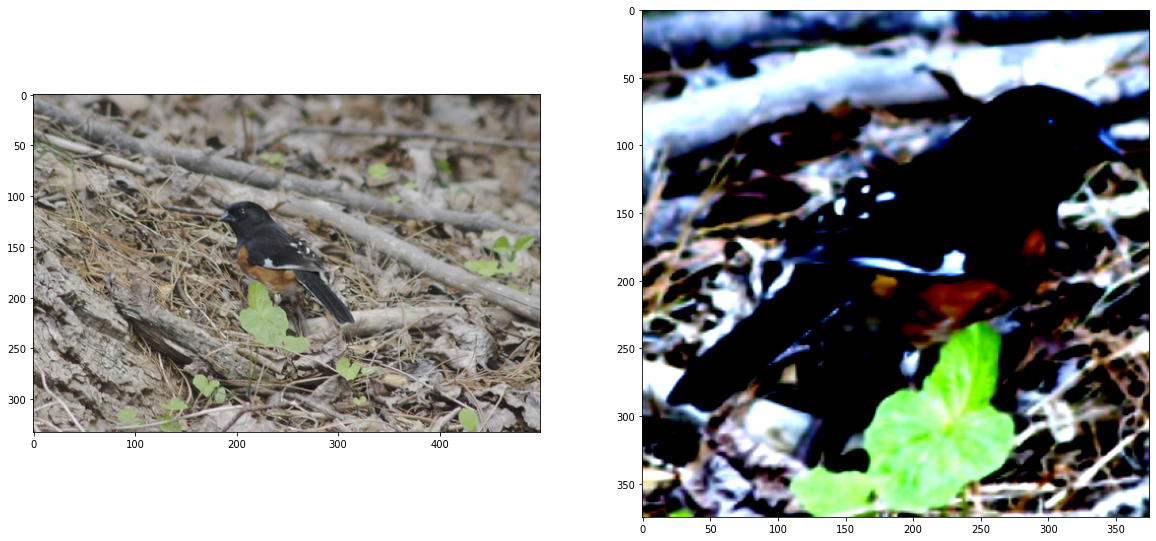

 75%|███████▌  | 3/4 [00:02<00:00,  1.13it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


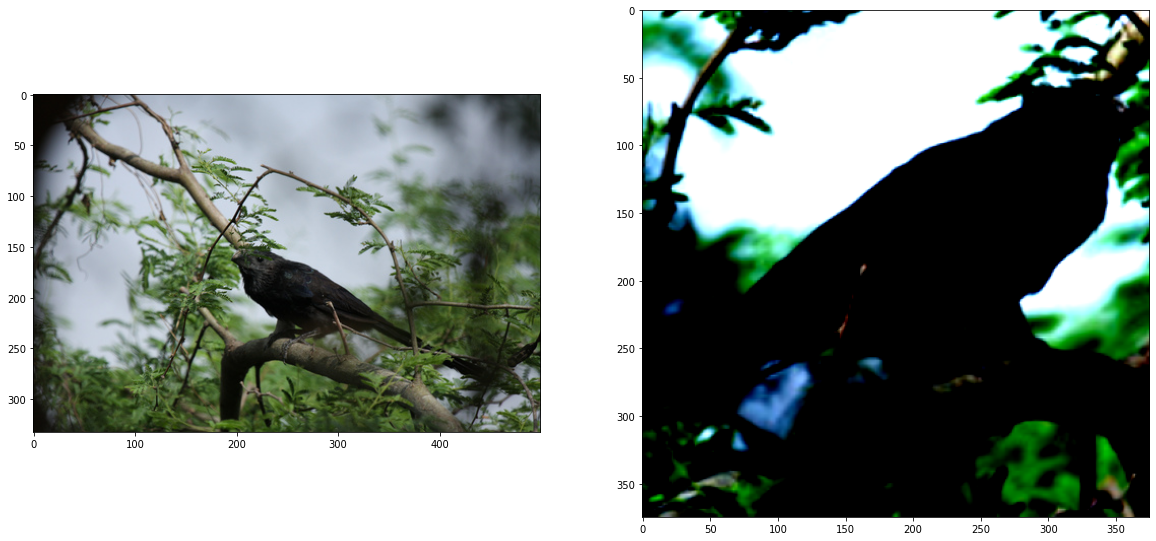

100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


In [16]:

test_dir = general_dir + '/test_transform'

def compare_images_transforms( data_transforms1, test_dir):
  for f in tqdm(os.listdir(test_dir)):
      if 'jpg' in f:
          fig = plt.figure(figsize=(20,20*2))

          fig.add_subplot(1, 2, 1)
          plt.imshow(pil_loader(test_dir + '/' + f))
          
          data1 = data_transforms1(pil_loader(test_dir + '/' + f))
          data1 = data1.view(1, data1.size(0), data1.size(1), data1.size(2))
          fig.add_subplot(1, 2, 2)
          plt.imshow(data1[0].permute(1, 2, 0).cpu())

          plt.show()

compare_images_transforms(transformer_train, test_dir)

In [18]:
# Choose model
model = BirdNet(backbone="resnext101_32x8d").to(device)
model.freeze()
model.unfreeze_few_layers()
model

# Parameters of the training
num_epochs = 10
learning_rate = 1e-4
criterion = [nn.CrossEntropyLoss()]
nb_classes = 20
grad_clip = 0.1
weight_decay = 1e-4
max_lr = 0.00005

# instantiate optimizer and scheduler
#optimizer = optim.Adam([{'params': list(model.children())[0].parameters(), 'lr': 1e-4},], lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) 
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

# Train the model
model, val_acc, val_loss, train_acc, train_loss, lrs = training(model, train_loader, val_loader, optimizer, scheduler, num_epochs, criterion, device, grad_clip)

# Test accuracy
# test_accuracy = test_model(model, test_loader, device)
# print('Test accuracy: {:.3f}'.format(test_accuracy))

# Print Accuracy and loss evolution 
print_accuracy_and_loss(val_acc, val_loss, train_acc, train_loss, lrs)

Train Epoch: 0 [0/948 (0%)]	Loss: 3.186993	Acc: 6%
Train Epoch: 0 [80/948 (8%)]	Loss: 3.203430	Acc: 6%
Train Epoch: 0 [160/948 (17%)]	Loss: 3.059611	Acc: 6%
Train Epoch: 0 [240/948 (25%)]	Loss: 3.071042	Acc: 6%
Train Epoch: 0 [320/948 (33%)]	Loss: 3.207628	Acc: 6%
Train Epoch: 0 [400/948 (42%)]	Loss: 2.994094	Acc: 12%
Train Epoch: 0 [480/948 (50%)]	Loss: 3.099430	Acc: 0%
Train Epoch: 0 [560/948 (58%)]	Loss: 3.125704	Acc: 0%
Train Epoch: 0 [640/948 (67%)]	Loss: 3.134216	Acc: 0%
Train Epoch: 0 [720/948 (75%)]	Loss: 2.978056	Acc: 12%
Train Epoch: 0 [800/948 (83%)]	Loss: 2.990655	Acc: 12%
Train Epoch: 0 [880/948 (92%)]	Loss: 2.963277	Acc: 6%
Validation set: Average loss: 2.8979, Accuracy: 16%

Train Epoch: 1 [0/948 (0%)]	Loss: 2.993823	Acc: 0%
Train Epoch: 1 [80/948 (8%)]	Loss: 2.636256	Acc: 31%
Train Epoch: 1 [160/948 (17%)]	Loss: 2.862599	Acc: 19%
Train Epoch: 1 [240/948 (25%)]	Loss: 3.051926	Acc: 0%
Train Epoch: 1 [320/948 (33%)]	Loss: 2.704046	Acc: 25%
Train Epoch: 1 [400/948 (42%)]	Lo

KeyboardInterrupt: ignored

### Transforms : CutMix

https://github.com/hysts/pytorch_cutmix

In [ ]:
def cutmix(batch, alpha):
    data, targets = batch

    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]


    lam = np.random.beta(alpha, alpha)

    image_h, image_w = data.shape[2:]
    cx = np.random.uniform(0, image_w)
    cy = np.random.uniform(0, image_h)
    w = image_w * np.sqrt(1 - lam)
    h = image_h * np.sqrt(1 - lam)
    x0 = int(np.round(max(cx - w / 2, 0)))
    x1 = int(np.round(min(cx + w / 2, image_w)))
    y0 = int(np.round(max(cy - h / 2, 0)))
    y1 = int(np.round(min(cy + h / 2, image_h)))

    data[:, :, y0:y1, x0:x1] = shuffled_data[:, :, y0:y1, x0:x1]
    targets = (targets, shuffled_targets, lam)

    return data, targets


class CutMixCollator:
    def __init__(self, alpha):
        self.alpha = alpha

    def __call__(self, batch):
        batch = torch.utils.data.dataloader.default_collate(batch)
        batch = cutmix(batch, self.alpha)
        return batch


class CutMixCriterion:
    def __init__(self, reduction):
        self.criterion = nn.CrossEntropyLoss(reduction=reduction)

    def __call__(self, preds, targets):
        targets1, targets2, lam = targets
        return lam * self.criterion(
            preds, targets1) + (1 - lam) * self.criterion(preds, targets2)



/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


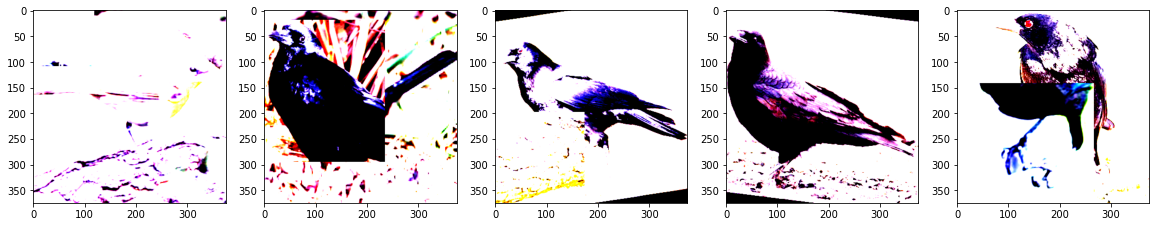

In [ ]:
# Test with custom stat
batch_s = 16
batch_s_val = batch_s*2

transformer_train = transforms.Compose([
    transforms.ToTensor(),
    #Padding(ratio=ratio_padding, fixed_size=size_padding),
    tv.transforms.RandomOrder([
      transforms.RandomHorizontalFlip(p=0.4),
      transforms.RandomRotation(10, resample=Image.BILINEAR),]),
    #tv.transforms.RandomCrop(img_size),
    #CorrectRatio(ratio_crop),
    #transforms.Resize(img_size),
    BirdCropper(device, ratio=ratio_padding, size_padding=size_padding),
    transforms.Resize(img_size),
    tv.transforms.Normalize(*custom_stats),
    ])

transformer_eval = transforms.Compose([
    transforms.ToTensor(),
    #Padding(ratio=ratio_padding, fixed_size=size_padding),
    BirdCropper(device),
    transforms.Resize(img_size),
    tv.transforms.Normalize(*custom_stats)
    ])

collator =  CutMixCollator(1)


# Image Loader
train_set = datasets.ImageFolder(new_data_file + "/train", transform=transformer_train)
val_set = datasets.ImageFolder(new_data_file + "/val", transform=transformer_eval)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_s, shuffle=True, collate_fn=collator)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_s, shuffle=True,)

print_images_from_loader(train_loader)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

Train Epoch: 0 [0/948 (0%)]	Loss: 2.951980	Acc: 15%
Train Epoch: 0 [80/948 (8%)]	Loss: 3.176433	Acc: 0%
No bird detected
Train Epoch: 0 [160/948 (17%)]	Loss: 3.090971	Acc: 11%
Train Epoch: 0 [240/948 (25%)]	Loss: 2.851032	Acc: 15%
No bird detected
Train Epoch: 0 [320/948 (33%)]	Loss: 3.111367	Acc: 5%
No bird detected
Train Epoch: 0 [400/948 (42%)]	Loss: 3.176097	Acc: 1%
Train Epoch: 0 [480/948 (50%)]	Loss: 2.816980	Acc: 7%
No predictions
Train Epoch: 0 [560/948 (58%)]	Loss: 3.214140	Acc: 0%
Train Epoch: 0 [640/948 (67%)]	Loss: 3.089554	Acc: 0%
Train Epoch: 0 [720/948 (75%)]	Loss: 3.078465	Acc: 6%
Train Epoch: 0 [800/948 (83%)]	Loss: 2.860522	Acc: 14%
No predictions
Train Epoch: 0 [880/948 (92%)]	Loss: 3.068301	Acc: 2%
No predictions
Validation set: Average loss: 2.8915, Accuracy: 11%

Train Epoch: 1 [0/948 (0%)]	Loss: 2.891843	Acc: 12%
Train Epoch: 1 [80/948 (8%)]	Loss: 2.884195	Acc: 12%
No bird detected
Train Epoch: 1 [160/948 (17%)]	Loss: 3.057506	Acc: 8%
Train Epoch: 1 [240/948 (25%

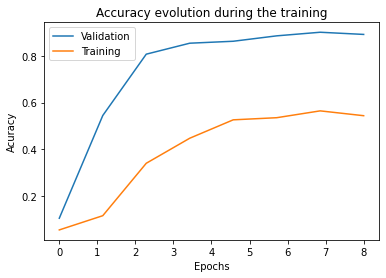

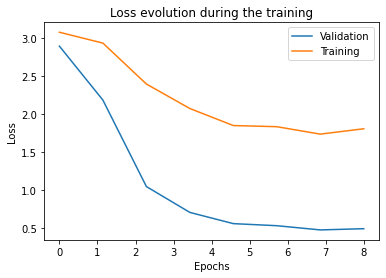

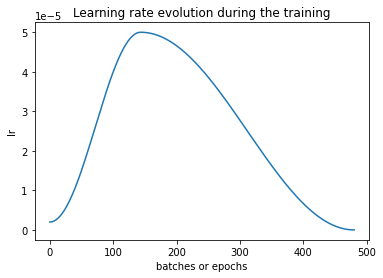

In [ ]:
# Parameters of the training

criterion = [CutMixCriterion(reduction='mean'), nn.CrossEntropyLoss()]
num_epochs = 10
models = []

num_epochs = 8
learning_rate = 1e-4
nb_classes = 20
grad_clip = 0.1
weight_decay = 1e-4
max_lr = 0.00005


# Choose mode
model = BirdNet(backbone='resnext101_32x8d').to(device)
model.freeze()
model.unfreeze_few_layers()

# model, optimizer etc
model = BirdNet(backbone='resnext101_32x8d',nb_classes=20, name="BirdResnet101_crop+cutmix").to(device)
model.freeze()
model.unfreeze_few_layers()
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, 
                                                steps_per_epoch=len(train_loader))
model, val_acc, val_loss, train_acc, train_loss, lrs = training(model, train_loader, val_loader, optimizer, scheduler, num_epochs, criterion, device, grad_clip)


print_accuracy_and_loss(val_acc, val_loss, train_acc, train_loss, lrs)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


No bird detected


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No bird detected


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


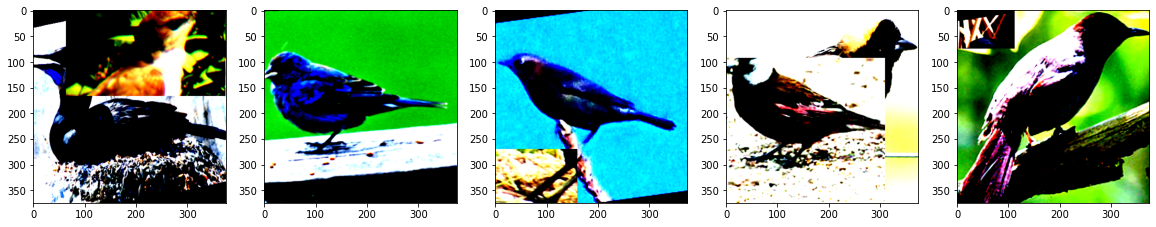

In [ ]:
# With ImageNet stats
batch_s = 16
batch_s_val = batch_s*2

transformer_train = transforms.Compose([
    transforms.ToTensor(),
    #Padding(ratio=ratio_padding, fixed_size=size_padding),
    tv.transforms.RandomOrder([
      transforms.RandomHorizontalFlip(p=0.4),
      transforms.RandomRotation(10, resample=Image.BILINEAR),]),
    #tv.transforms.RandomCrop(img_size),
    #CorrectRatio(ratio_crop),
    #transforms.Resize(img_size),
    BirdCropper(device, ratio=ratio_padding, size_padding=size_padding),
    transforms.Resize(img_size),
    tv.transforms.Normalize(*stats),
    ])

transformer_eval = transforms.Compose([
    transforms.ToTensor(),
    #Padding(ratio=ratio_padding, fixed_size=size_padding),
    BirdCropper(device),
    transforms.Resize(img_size),
    tv.transforms.Normalize(*stats)
    ])

collator =  CutMixCollator(1)


# Image Loader
train_set = datasets.ImageFolder(new_data_file + "/train", transform=transformer_train)
val_set = datasets.ImageFolder(new_data_file + "/val", transform=transformer_eval)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_s, shuffle=True, collate_fn=collator)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_s, shuffle=True,)

print_images_from_loader(train_loader)

Train Epoch: 0 [0/948 (0%)]	Loss: 3.103554	Acc: 3%
Train Epoch: 0 [80/948 (8%)]	Loss: 3.071031	Acc: 0%
Train Epoch: 0 [160/948 (17%)]	Loss: 3.149230	Acc: 3%
No predictions
Train Epoch: 0 [240/948 (25%)]	Loss: 3.077690	Acc: 1%
No bird detected
Train Epoch: 0 [320/948 (33%)]	Loss: 3.085940	Acc: 3%
Train Epoch: 0 [400/948 (42%)]	Loss: 3.113373	Acc: 12%
No bird detected
Train Epoch: 0 [480/948 (50%)]	Loss: 3.138948	Acc: 12%
No bird detected
Train Epoch: 0 [560/948 (58%)]	Loss: 3.042771	Acc: 2%
Train Epoch: 0 [640/948 (67%)]	Loss: 3.075044	Acc: 7%
Train Epoch: 0 [720/948 (75%)]	Loss: 3.051260	Acc: 11%
Train Epoch: 0 [800/948 (83%)]	Loss: 3.167355	Acc: 4%
Train Epoch: 0 [880/948 (92%)]	Loss: 3.123922	Acc: 3%
No predictions
No predictions
Validation set: Average loss: 2.9001, Accuracy: 15%

Train Epoch: 1 [0/948 (0%)]	Loss: 2.947744	Acc: 10%
Train Epoch: 1 [80/948 (8%)]	Loss: 2.931201	Acc: 17%
No predictions
Train Epoch: 1 [160/948 (17%)]	Loss: 2.981605	Acc: 12%
Train Epoch: 1 [240/948 (25%)]

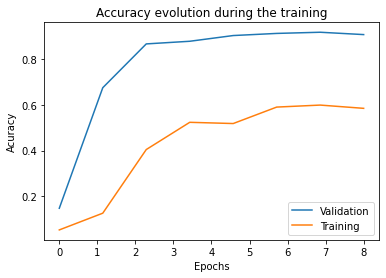

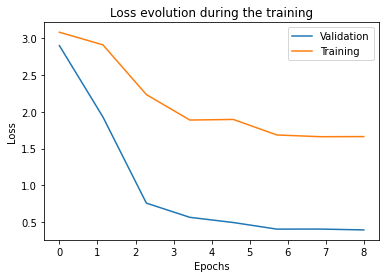

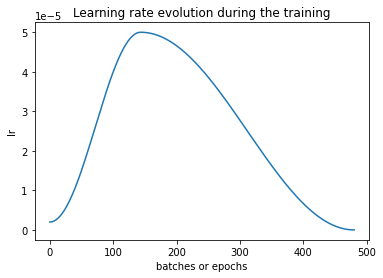

In [ ]:
# Parameters of the training

criterion = [CutMixCriterion(reduction='mean'), nn.CrossEntropyLoss()]
num_epochs = 10
models = []

num_epochs = 8
learning_rate = 1e-4
nb_classes = 20
grad_clip = 0.1
weight_decay = 1e-4
max_lr = 0.00005


# Choose mode
model = BirdNet(backbone='resnext101_32x8d').to(device)
model.freeze()
model.unfreeze_few_layers()

# model, optimizer etc
model = BirdNet(backbone='resnext101_32x8d',nb_classes=20, name="BirdResnet101_crop+cutmix").to(device)
model.freeze()
model.unfreeze_few_layers()
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, 
                                                steps_per_epoch=len(train_loader))
model, val_acc, val_loss, train_acc, train_loss, lrs = training(model, train_loader, val_loader, optimizer, scheduler, num_epochs, criterion, device, grad_clip)


print_accuracy_and_loss(val_acc, val_loss, train_acc, train_loss, lrs)

## Evaluation 

Get the output on the test set

### Classic evaluation of a single model

In [ ]:
#EVAL
batch_s = 32
batch_s_val = 64
img_size = (375,375)

weights_path = experiment_dir + '/BirdResnet_3/14.pth'
test_dir = new_data_file + '/test/mistery_category/'
output_file = experiment_dir + "/BirdResnet_14.csv"

state_dict = torch.load(weights_path)
model = BirdNet()
model.load_state_dict(state_dict)
model.eval()

transformer_eval = tv.transforms.Compose([
    transforms.ToTensor(),
    #ZeroPadding(ratio=ratio_padding, fixed_size=size_padding),
    tv.transforms.CenterCrop(img_size),
    tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],)
    ])


loss, acc = compute_validation(model.to(device), val_loader, criterion, device)

evaluation_file(model, transformer_eval, test_dir, general_dir, output_file)

### Cross Validation and bagging

In order to get a better accuracy, we can train the model on all the data we have access to, which also includes the validation dataset. In that purpose, we use cross validation to train 4 differents models on a different train set. 
Then we do a bagging of all the 4 model to predict the ouptut.

We also do bagging between differents models, but it turns out that Resnet101 performs better alone (it is also the heavier model that we trained).

In [10]:
batch_s = 16
batch_s_val = batch_s*2


transformer_train = transforms.Compose([
    transforms.ToTensor(),
    #Padding(ratio=ratio_padding, fixed_size=size_padding),
    tv.transforms.RandomOrder([
      transforms.RandomHorizontalFlip(p=0.4),
      transforms.RandomRotation(10, resample=Image.BILINEAR),]),
    #tv.transforms.RandomCrop(img_size),
    #CorrectRatio(ratio_crop),
    #transforms.Resize(img_size),
    BirdCropper(device, ratio=ratio_padding, size_padding=size_padding, detection_threshold=0.2),
    transforms.Resize(img_size),
    tv.transforms.Normalize(*stats),
    ])

transformer_eval = transforms.Compose([
    transforms.ToTensor(),
    #Padding(ratio=ratio_padding, fixed_size=size_padding),
    BirdCropper(device),
    transforms.Resize(img_size),
    tv.transforms.Normalize(*stats)
    ])

# Image Loader
train_set = datasets.ImageFolder(new_data_file + "/train", transform=transformer_train)
val_set = datasets.ImageFolder(new_data_file + "/val", transform=transformer_train)
dataset = train_set + val_set

nfolds = 4
nsamples = len(dataset)
split = nsamples // nfolds
folds = data.random_split(dataset, [split]*(nfolds-1) + [nsamples - split*(nfolds-1)])


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [ ]:

num_epochs = 10
models = []

num_epochs = 7
learning_rate = 1e-4

#criterion = [CutMixCriterion(reduction='mean'), nn.CrossEntropyLoss()]
criterion = [nn.CrossEntropyLoss()]
nb_classes = 20
grad_clip = 0.1
weight_decay = 1e-4
max_lr = 0.00005

for k in range(nfolds):
  train_dataset = copy.deepcopy(folds)
  del train_dataset[k]
  train_dataset = data.ConcatDataset(train_dataset)
  val_dataset = copy.deepcopy(folds[k])

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_s, shuffle=True)
  #train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_s, shuffle=True, collate_fn=collator)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_s, shuffle=True,)

  # model, optimizer etc
  model = BirdNet(backbone='resnext101_32x8d',nb_classes=20, name="BirdResnet101_crop_"+str(k)).to(device)
  model.freeze()
  model.unfreeze_few_layers()
  optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, 
                                                steps_per_epoch=len(train_loader))
  model, val_acc, val_loss, train_acc, train_loss, lrs = training(model, train_loader, val_loader, optimizer, scheduler, num_epochs, criterion, device, grad_clip)
  models.append(model)

  print_accuracy_and_loss(val_acc, val_loss, train_acc, train_loss, lrs)


In [ ]:
img_size = (375,375)
test_dir = new_data_file + '/test/mistery_category/'
output_file = experiment_dir + "/BirdResnet_bagging_Resnet101_cutMix.csv"
# All Resnet
# weights_path_ = ['/BirdResnet101_0/7.pth', '/BirdResnet101_1/7.pth', '/BirdResnet101_2/5.pth', '/BirdResnet101_3/6.pth',
#                 '/BirdResnet152_0/7.pth', '/BirdResnet152_1/7.pth', '/BirdResnet152_2/7.pth', '/BirdResnet152_3/7.pth',
#                 '/BirdResnet_0/6.pth', '/BirdResnet_1/6.pth', '/BirdResnet_2/6.pth', '/BirdResnet_3/6.pth']

# Resnet and Resnet with BirdCrop and CutMix
#weights_path = ['/BirdResnet101_crop_and_cut_2/6.pth', '/BirdResnet101_crop_and_cut_3/.pth', '/BirdResnet101_crop_and_cut_0/7.pth', '/BirdResnet101_crop_and_cut_1/6.pth']

# Resnet 101 BirdCrop
weights_path = ['/BirdResnet101_crop_0/7.pth','/BirdResnet101_crop_1/7.pth', '/BirdResnet101_crop_2/6.pth', '/BirdResnet101_crop_3/6.pth', '/BirdResnet101_crop_and_cut_2/6.pth', '/BirdResnet101_crop_and_cut_3/7.pth', '/BirdResnet101_crop_and_cut_0/7.pth', '/BirdResnet101_crop_and_cut_1/6.pth']
 
List_models = ['resnext101_32x8d','resnext101_32x8d','resnext101_32x8d','resnext101_32x8d','resnext101_32x8d','resnext101_32x8d','resnext101_32x8d','resnext101_32x8d']

models = []
for i in range(len(weights_path)):
  state_dict = torch.load(experiment_dir + weights_path[i])
  model = BirdNet(backbone=List_models[i]).to(device)
  model.freeze()
  model.unfreeze_few_layers()
  model.load_state_dict(state_dict)
  models.append(model)


transformer_eval = transforms.Compose([
    transforms.ToTensor(),
    #Padding(ratio=ratio_padding, fixed_size=size_padding),
    BirdCropper(device),
    transforms.Resize(img_size),
    tv.transforms.Normalize(*stats)
    ])

evaluation_file_bagging(models, transformer_eval, test_dir, general_dir, output_file)